# Step 0: Data Preparation and Preprocessing

## 1. Import Dependencies

First, we need to load all the tools (libraries) we need for our project.

In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

## 2. Load Raw Data

Here, we load our customer dataset from the file.

In [9]:
df = pd.read_csv('data/raw/dataset.csv')
print("Successfully loaded dataset.")
print(f"Shape: {df.shape}")
print("First 5 rows:")
display(df.head())

Successfully loaded dataset.
Shape: (9993, 11)
First 5 rows:


,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScoreBins
0,France,Female,3.76120,2,0.00,1,1,1,101348.88,1,Fair
1,Spain,Female,3.73767,1,83807.86,1,0,1,112542.58,0,Fair
2,France,Female,3.76120,8,159660.80,3,1,0,113931.57,1,Poor
3,France,Female,3.68668,1,0.00,2,0,0,93826.63,0,Good
4,Spain,Female,3.78419,2,125510.82,1,1,1,79084.10,0,Excellent


## 3. Feature Engineering and Preprocessing

This is where we clean and prepare our data for the model.

### Mnemonic: **P-P-T** (Pipelines, Preprocessor, Transform)
*   **P** - **Pipelines**: Create separate cleaning steps for different types of data (numbers, categories).
*   **P** - **Preprocessor**: Combine all the pipelines into one single tool.
*   **T** - **Transform**: Use the preprocessor to clean the entire dataset.

### 3.1. Define Feature Categories

We group our columns based on their data type.

In [10]:
remainder_features = ['NumOfProducts', 'HasCrCard', 'IsActiveMember']
numerical_features = ['Age', 'Tenure', 'Balance', 'EstimatedSalary']
nominal_features = ['Gender', 'Geography']
ordinal_features = ['CreditScoreBins']

### 3.2. Create Preprocessing Pipelines

We create a set of steps (a "pipeline") for each data type to handle missing values and scale the data correctly.

In [11]:
numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

nominal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]
)

ordinal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OrdinalEncoder())
    ]
)

### 3.3. Combine Pipelines with ColumnTransformer

Now, we combine all our pipelines into a single, powerful preprocessor.

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', ordinal_transformer, ordinal_features),
    ],
    remainder='passthrough' # Keep the remainder features
)

### 3.4. Apply Transformations and Create Final DataFrame

We use our preprocessor to transform the data and create a final, clean DataFrame.

In [13]:
# 🛡️ Step 1: Create safe copy of original data
print("📋 Creating safe copy of data...")
df_copy = df.copy()

# 🔧 Step 2: Apply all preprocessing transformations
print("⚙️ Applying preprocessing pipeline...")
transformed_array = preprocessor.fit_transform(df_copy)
print(f"✅ Transformed shape: {transformed_array.shape}")

# 🏷️ Step 3: Reconstruct column names (sklearn loses them)
print("🏷️ Reconstructing column names...")

# Get expanded names for one-hot encoded features
nominal_expanded_names = preprocessor.named_transformers_['nom']['encoder'].get_feature_names_out(nominal_features)

# Combine all feature names in correct order
final_feature_names = (
    numerical_features +           # Age, Tenure, Balance, EstimatedSalary
    list(nominal_expanded_names) + # Gender_Male, Geography_France, etc.
    ordinal_features +             # CreditScoreBins  
    remainder_features             # NumOfProducts, HasCrCard, IsActiveMember
)

print(f"📊 Total features after transformation: {len(final_feature_names)}")
print(f"   Original features: {df.shape[1]-1}")  # -1 for target
print(f"   New features: {len(final_feature_names)}")

# 📊 Step 4: Convert back to DataFrame with proper column names
df_features = pd.DataFrame(transformed_array, columns=final_feature_names)

# 🎯 Step 5: Add target variable back
df_final = pd.concat([
    df_features, 
    df['Exited'].reset_index(drop=True)
], axis=1)

print("🎉 Preprocessing complete!")
print(f"📏 Final dataset shape: {df_final.shape}")
display(df_final.head())


📋 Creating safe copy of data...
⚙️ Applying preprocessing pipeline...
✅ Transformed shape: (9993, 14)
🏷️ Reconstructing column names...
📊 Total features after transformation: 13
   Original features: 10
   New features: 13


ValueError: Shape of passed values is (9993, 14), indices imply (9993, 13)

## 4. Handle Class Imbalance using SMOTE

Our data has many more 'Not Churn' customers than 'Churn' customers. This can bias our model. We use **SMOTE** to create new, synthetic 'Churn' data points to balance things out.

### Mnemonic: **S-B-V** (Split, Balance, Visualize)
*   **S** - **Split**: First, split data into training and testing sets.
*   **B** - **Balance**: Apply SMOTE *only* to the training data.
*   **V** - **Visualize**: Create charts to see the data before and after balancing.

In [ ]:
X = df_final.drop(columns=['Exited'])
Y = df_final['Exited']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

print("Class distribution before SMOTE:")
print(Y_train.value_counts())
print("\nClass distribution after SMOTE:")
print(pd.Series(Y_train_resampled).value_counts())

### 4.1. Visualize Class Distribution

NameError: name 'Y_train' is not defined

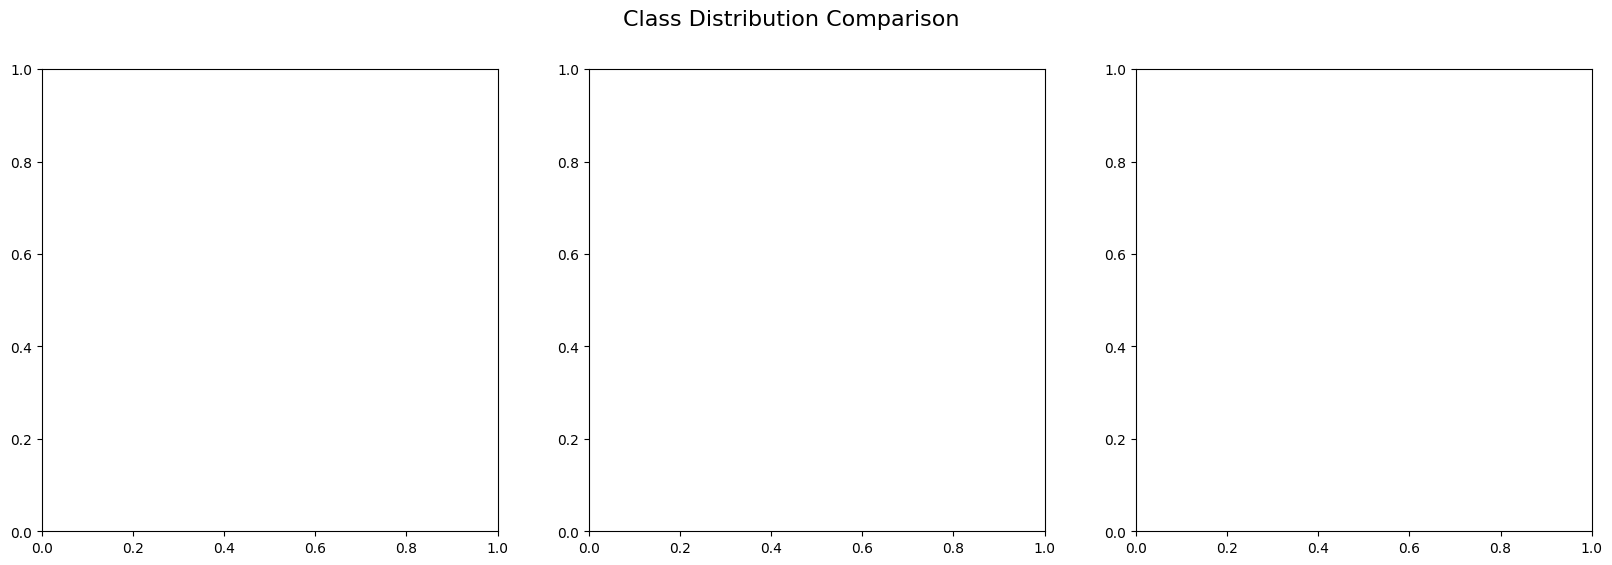

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Class Distribution Comparison', fontsize=16)

# Before SMOTE
Y_train.value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Before SMOTE (Training Set)')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', linestyle='--')

# After SMOTE
pd.Series(Y_train_resampled).value_counts().plot(kind='bar', ax=axes[1], color=['skyblue', 'salmon'])
axes[1].set_title('After SMOTE (Training Set)')
axes[1].grid(axis='y', linestyle='--')

# Test Set
Y_test.value_counts().plot(kind='bar', ax=axes[2], color=['lightgreen', 'gold'])
axes[2].set_title('Test Set (Untouched)')
axes[2].grid(axis='y', linestyle='--')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5. Save Processed Data Artifacts

Finally, we save our prepared datasets to files. This way, we can use them in the next steps without re-running the preparation process.

In [ ]:
np.savez('artifacts/X_train.npz', X_train_resampled)
np.savez('artifacts/Y_train.npz', Y_train_resampled)
np.savez('artifacts/X_test.npz', X_test.values)
np.savez('artifacts/Y_test.npz', Y_test.values)

print("Saved processed data artifacts to the 'artifacts/' directory.")